In [1]:
import h5py
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
filepath = 'csv/'
filename = 'scopetest_CH2.csv'

traces = np.loadtxt(filepath+filename,delimiter=',')
num_traces = traces.shape[1] - 1 # Subtract the first (time) column
print('Num traces in this file:', num_traces)

Num traces in this file: 10


In [3]:
# Start at peak voltage and find "crossing points" below the baseline+rms
# To account for statistical fluctuations from noise, declare a bound
# only when the voltage falls below the baseline+rms value some number
# of times (the threshold)
def find_integration_bounds(voltage, baseline, baseline_rms, verbose=False):
    lbound = 0
    rbound = len(voltage)
    voltage_peak = np.amax(voltage)
    peak_index = np.argmax(voltage)
    
    num_crosses = 0
    # TODO: Is 10 good enough? Too many?
    cross_threshold = 10
    for index in range(peak_index, len(voltage)):
        if voltage[index] < (baseline + baseline_rms):
            if verbose:
                print('Found voltage cross point at index', index, 'with value', voltage[index])
            num_crosses += 1
            if num_crosses == cross_threshold:
                if verbose:
                    print('Setting rbound', index)
                rbound = index
                break
            
    num_crosses = 0
    # Now the same thing but for left bound
    for index in range(peak_index, 0, -1):
        if voltage[index] < (baseline + baseline_rms):
            if verbose:
                print('Found voltage cross point at index', index, 'with value', voltage[index])
            num_crosses += 1
            if num_crosses == cross_threshold:
                if verbose:
                    print('Setting lbound', index)
                lbound = index
                break
    
    return lbound, rbound

In [6]:
# The first column of traces will contain time values. All other columns contain voltages
trace_time = traces[:, 0]
voltages   = traces[:, 1:]
print('Voltages shape:', voltages.shape)
num_traces = voltages.shape[1] 
print('Num traces:', num_traces)
integrals = []
alt_integrals = []
verbose = False
save_plots = True
for i in range(num_traces):
    if verbose: print('-------START LOOP ', i, '----------')
    voltage = voltages[:,i]
    
    # TODO: Hard-coding alert! 4900 comes from looking at lbounds output by find_integration_bounds()
    voltage_baseline = np.array(voltage[:4900])
    baseline = np.mean(voltage_baseline)
    baseline_rms = np.std(voltage_baseline)
    
    lbound, rbound = find_integration_bounds(voltage, baseline, baseline_rms, verbose)
    voltage_baseline_subtracted = voltage - baseline
    integrals.append(np.sum(voltage_baseline_subtracted[lbound:rbound+1]))
    alt_integrals.append(np.trapz(voltage_baseline_subtracted[lbound:rbound+1], x=trace_time[lbound:rbound+1]))
    
    if verbose:
        print('Baseline value:', baseline)
        print('Baseline RMS:', baseline_rms)
        print('Integral', i, 'from sum:', integrals[i])
        print('Integral from trap rule:', alt_integral)
    
    ### Plot for validating/debugging ###
    if save_plots:
        plt.figure(figsize=(10, 8))
        plt.plot(trace_time, voltage_baseline_subtracted, color='black')
        # Vertical lines at integration bounds
        plt.axvline(x=trace_time[lbound], color='cyan')
        plt.axvline(x=trace_time[rbound], color='cyan')
        # Horizontal lines at baseline and baseline +/- rms
        baseline = 0 # Since we're plotting baseline-corrected voltage
        plt.axhline(y=baseline, color='r')
        plt.axhline(y=baseline+baseline_rms, color='r', linestyle='--')
        plt.axhline(y=baseline-baseline_rms, color='r', linestyle='--')
        plt.xlabel(r'Time [$\mu$s]')
        plt.ylabel('Voltage [V]')
        plt.savefig(f"waveform_{i:03}_{filename.removesuffix('.csv')}.png")
        plt.close()
        #plt.show()
    if verbose: print('-------END LOOP ', i, '----------')

Voltages shape: (9952, 10)
Num traces: 10


(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 9.]),
 array([ 0.        ,  2.9261031 ,  5.8522062 ,  8.77830931, 11.70441241,
        14.63051551, 17.55661861, 20.48272171, 23.40882482, 26.33492792,
        29.26103102]),
 <BarContainer object of 10 artists>)

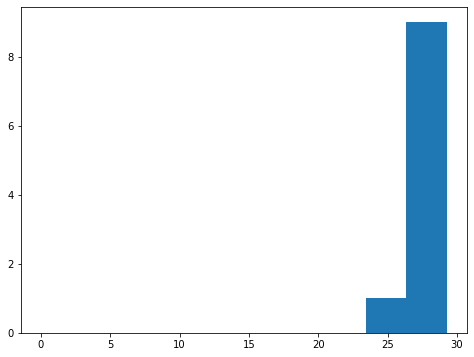

In [100]:
plt.figure(figsize=(8,6))
plt.hist(integrals, range=(0, np.max(integrals)))

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 9.]),
 array([0.00000000e+00, 2.92609478e-09, 5.85218955e-09, 8.77828433e-09,
        1.17043791e-08, 1.46304739e-08, 1.75565687e-08, 2.04826634e-08,
        2.34087582e-08, 2.63348530e-08, 2.92609478e-08]),
 <BarContainer object of 10 artists>)

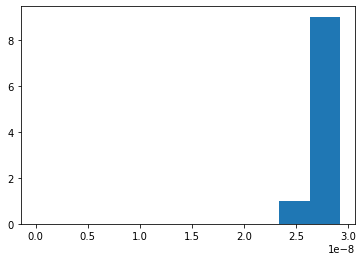

In [85]:
plt.hist(alt_integrals, range=(0, np.max(alt_integrals)))